In [1]:
import sys; sys.path.insert(0, '../../');
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import methods.util as util
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats

import methods.shared as shared
import methods.sim_barcodes as sim

from importlib import reload
reload(util);
reload(shared);
from matplotlib.backends.backend_pdf import PdfPages

In [67]:
shared.well_to_medium_map
ids_tsv = open(f'{data_dir}/github_data/plate_well_ids.tsv', 'w')
ids_tsv.write('Plate\tWell\tEvolution carbon source\tBarcode inoculum\n')

for plate in ['p1', 'p2']:
    for letter in 'ABCDEFGH':
        for number in range(1,13):
            well_id = f'{letter}{number}'
            well_str = f'{plate}_{well_id}'

            if well_str in shared.well_to_medium_map:
                medium, barcode_inoc = shared.well_to_medium_map[well_str]
                ids_tsv.write(f'{plate.strip("p")}\t{well_id}\t{medium}\t{barcode_inoc}\n')
            else:
                ids_tsv.write(f'{plate.strip("p")}\t{well_id}\tblank\t\n')
            
ids_tsv.close()
    # for k,v in shared.well_to_medium_map.items():
        # print(f'{k}\t{v}\n')
        # f.write(f'{k}\t{v}\n')

In [68]:
def convert_to_float(e):
    if e == '':
        return 0
    else: return float(e)
# 16S

## merge species of same name
community_arrays = {}
with open(f'{data_dir}/Github_data/Btbarcodes_me2_16S.tsv', 'r') as f:
    header = next(f)
    header_items = header.split('\t')
    asv_ids = np.array([int(e.strip('feature__')) for e in header.strip('\n').split('\t')[5:]])

    lines = f.readlines()
    
    species_identities = np.array([str(e) for e in lines[-1].strip('\n').split('\t')[5:]])
    asv_species_map = {asv_id:species for asv_id, species in zip(asv_ids, species_identities)}

    day0_frequencies = np.array([convert_to_float(e) for e in lines[0].strip('\n').split('\t')[5:]])
    for line in lines[2:-1]:
        line_items = line.strip('\n').split('\t')
        mouse, iso, day = [int(e) for e in line_items[1:4]]
        if iso == 116:
            mouse += 10
        if iso == 118:
            mouse += 15
            continue

        freqs = np.array([convert_to_float(e) for e in line_items[5:]])


        if mouse not in community_arrays:
            community_arrays[mouse] = {'timepoints':[0], 'freqs':[np.copy(day0_frequencies)]}

        if day in community_arrays[mouse]['timepoints']:
            continue
        community_arrays[mouse]['timepoints'].append(day)
        community_arrays[mouse]['freqs'].append(np.array(freqs))

master_array = []
for mouse, freq_dict in community_arrays.items():
    if mouse not in [1, 2, 3, 4, 5, 11, 12, 13, 14, 15]:
        continue
    for freqs in freq_dict['freqs']:
        master_array.append(freqs)
master_array = np.array(master_array)

merge_asvs = []
for i in range(40):
    for j in range(i+1, master_array.shape[-1]):
        if np.corrcoef(np.log(master_array[:,i]+1e-5), np.log(master_array[:,j]+1e-5))[0][1] > 0.9:
            print("Merge highly correlated:", i, j, species_identities[i], species_identities[j], np.corrcoef(np.log(master_array[:,i]+1e-5), np.log(master_array[:,j]+1e-5))[0][1])
            merge_asvs.append((i,j))
            # fig, ax = plt.subplots()
            # ax.scatter(master_array[:,i], master_array[:,j])
            # ax.set_yscale('log'); ax.set_xscale('log')
            # ax.set_title(f'{species_identities[i]} vs {species_identities[j]}')
            # util.plot_diagonal(ax)
        
## merge asvs in master array
for i, j in merge_asvs:
    master_array[:,i] += master_array[:,j]
    master_array[:,j] = 0
# delete mergeds asvs
to_be_deleted = [j for i, j in merge_asvs]
master_array = np.delete(master_array, to_be_deleted, axis=1)
asv_ids = np.delete(asv_ids, to_be_deleted)
species_identities = np.delete(species_identities, to_be_deleted)
asv_species_map = {asv_id:species for asv_id, species in zip(asv_ids, species_identities)}

for mouse in community_arrays.keys():
    community_arrays[mouse]['freqs'] = np.array(community_arrays[mouse]['freqs'])
    for i, j in merge_asvs:
        community_arrays[mouse]['freqs'][:,i] += community_arrays[mouse]['freqs'][:,j]
        community_arrays[mouse]['freqs'][:,j] = 0
    community_arrays[mouse]['freqs'] = np.delete(community_arrays[mouse]['freqs'], to_be_deleted, axis=1)

max_freqs_in_each_mouse = np.array([np.max(community_arrays[mouse]['freqs'][1:], axis=0) for mouse in community_arrays.keys()])

cutoff = (max_freqs_in_each_mouse > 1e-2).sum(axis=0) > 1
asvs_to_label = np.array(asv_ids)[cutoff]
# print( ((master_array>1e-2).sum(axis=0) > 0).sum() )
print(np.array(asv_ids)[cutoff], np.array(species_identities)[cutoff])
# print(cutoff.sum())

Merge highly correlated: 0 35 Bacteroides intestinalis Bacteroides intestinalis 0.9290657170523764
Merge highly correlated: 8 16 Phocaeicola vulgatus uncultured Bacteroides 0.9769957997705457
Merge highly correlated: 19 30 Lacrimispora celerecrescens Uncultured Lachnospiraceae 0.916938107336702
Merge highly correlated: 19 31 Lacrimispora celerecrescens Uncultured Lachnospiraceae 0.921854553529667
Merge highly correlated: 37 38 Anaerostipes hadrus Anaerostipes hadrus 0.9892636763512851
[ 1  2  3  4  5  6  7  8  9 10 11 12 15 16 17 18 20 21 22 25 27 30] ['Bacteroides intestinalis' 'Bacteroides uniformis' 'Bacteroides caccae'
 'Bacteroides thetaiotaomicron' 'Bacteroides fragilis'
 'Parabacteroides distasonis' 'Bacteroides uniformis'
 'Akkermansia muciniphila' 'Phocaeicola vulgatus' 'Enterococcus faecium'
 'Escherichia fergusonii' 'Hungatella effluvii' 'Enterocloster bolteae'
 'Bacteroides stercoris' 'Eisenbergiella tayi'
 'Lachnoclostridium pacaense' 'Hungatella hathewayi'
 'Faecalicatena

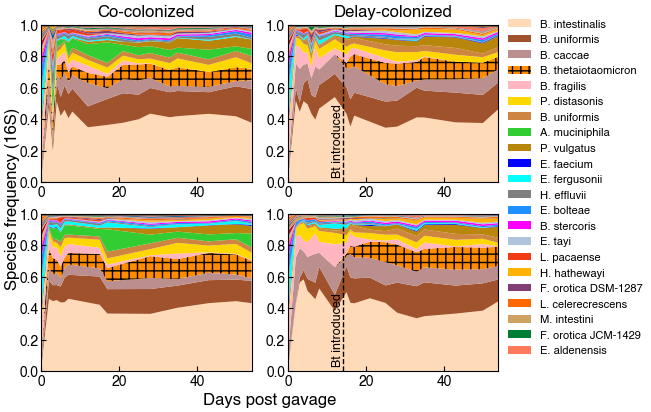

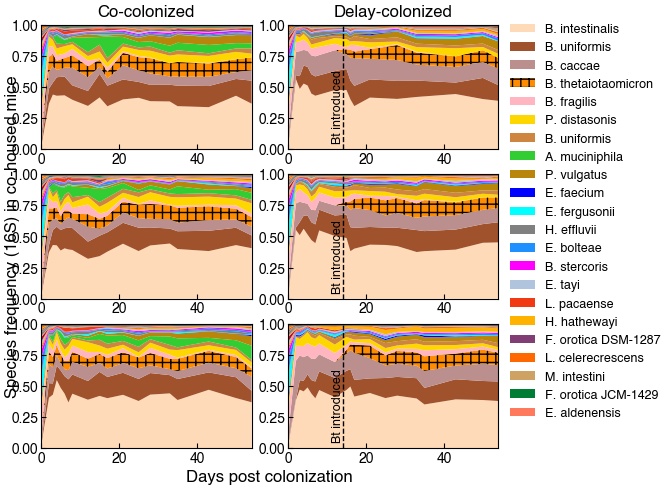

In [80]:
def muller_16s_plot(ax, times, freqs, asv_ids, colors, labels, alpha=1):
    """ freqs has dimensions of (time, bc freq).
     times and freqs.shape[0] should have same dimension. """
    cum_freqs = np.cumsum(freqs, axis=1)

    asv = asv_ids[0]
    ax.fill_between(times, np.zeros(len(times)), cum_freqs[:, 0], facecolor=colors[asv], label=labels[asv], alpha=alpha)

    for i in range(freqs.shape[1]-2):
        asv = asv_ids[i+1]
        if asv in asv_labels and asv_labels[asv] == 'B. thetaiotaomicron':
            hatch = '++'
        else:
            hatch = None
        ax.fill_between(times, cum_freqs[:, i], cum_freqs[:, i+1], facecolor=colors[asv], label=labels[asv], hatch=hatch, alpha=alpha)

    last_asv = asv_ids[-1]
    ax.fill_between(times, cum_freqs[:, freqs.shape[1]-2], cum_freqs[:, freqs.shape[1]-1], color=colors[last_asv], label=labels[last_asv], alpha=alpha)
    # ax.legend()

fig = plt.figure( figsize=(8,4.5))
gs = plt.GridSpec(2, 3, width_ratios=(1, 1, 0.6), figure=fig)
species_colors = [KELLY_COLORS[i%len(KELLY_COLORS)] for i in range(0, 56)]

asv_colors = {asvs_to_label[0]: 'peachpuff',
               asvs_to_label[1]: 'sienna',
                asvs_to_label[2]: 'rosybrown',
                  asvs_to_label[3]: 'darkorange',
                  asvs_to_label[4]: 'lightpink',
                  asvs_to_label[5]: 'gold',
                  asvs_to_label[6]: 'peru',
                  asvs_to_label[7]: 'limegreen', # akkermansia
                  asvs_to_label[8]: 'darkgoldenrod',
                  asvs_to_label[9]: 'blue',
                  asvs_to_label[10]: 'cyan',
                  asvs_to_label[11]: 'grey',
                  asvs_to_label[12]: 'dodgerblue',
                  asvs_to_label[13]: 'fuchsia',
                  asvs_to_label[14]: 'lightsteelblue'}
asv_colors = asv_colors | {asv_id: KELLY_COLORS[asv_id%len(KELLY_COLORS)] for asv_id in asv_ids if asv_id not in asv_colors}
asv_labels = {}
for asv in asv_ids:
    if asv not in asvs_to_label:
        asv_labels[asv] = ''
    else:
        species = asv_species_map[asv]
        species_items = species.strip(' ').split(' ')
        if len(species_items) == 2:
            species = f'{species_items[0][0]}' + '. ' + species_items[1]
        elif len(species_items) == 3:
            species = species_items[0][0] + '. ' + species_items[1] + ' ' + species_items[2]
        else:
            print('ah!')
        asv_labels[asv] = species


outer_ax = fig.add_subplot(gs[:, :2])
util.turn_off_ax(outer_ax)
outer_ax.set_xlabel('Days post gavage', fontsize=12, labelpad=15)
outer_ax.set_ylabel('Species frequency (16S)', fontsize=12, labelpad=15)

for m, mouse in enumerate([1, 2, 11, 12]):
    ax = fig.add_subplot(gs[m%2, m//2])

    if m == 0:
        ax.set_title('Co-colonized', fontsize=12)
    if m == 2:
        ax.set_title('Delay-colonized', fontsize=12)

    days, freqs = np.array(community_arrays[mouse]['timepoints']), np.array(community_arrays[mouse]['freqs'])
    if mouse > 10:
        ax.axvline(14, color='black', linestyle='dashed', lw=1)
        bt_intro = ax.text(11.2, 0.05, r'Bt introduced', fontsize=9, rotation=90)
        # bt_intro.set_bbox(dict(facecolor='none', edgecolor='black', linestyle='dashed'))
    muller_16s_plot(ax, days, freqs, asv_ids, asv_colors, asv_labels)

    if m == 3:
        ax.legend(bbox_transform=ax.transAxes, loc='upper left', bbox_to_anchor=(1, 2.30), ncol=1, frameon=False, fontsize=8)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 54)

fig.savefig(f'{plot_dir}/fig5_16s_composition.pdf')
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/fig5_16s_composition.svg', format='svg', transparent=True, bbox_inches='tight')
fig.savefig(f'../figures/fig5_16s_composition.pdf', transparent=True, bbox_inches='tight')

#### si
fig = plt.figure( figsize=(8,5.5))
gs = plt.GridSpec(3, 3, width_ratios=(1, 1, 0.6), figure=fig)

outer_ax = fig.add_subplot(gs[:, :2])
util.turn_off_ax(outer_ax)
outer_ax.set_xlabel('Days post colonization', fontsize=12, labelpad=15)
outer_ax.set_ylabel('Species frequency (16S) in co-housed mice', fontsize=12, labelpad=15)

for col, mice in enumerate([[3, 4, 5], [13, 14, 15]]):
    for row, mouse in enumerate(mice):
        ax = fig.add_subplot(gs[row, col])

        if row == 0 and col == 0:
            ax.set_title('Co-colonized', fontsize=12)
        if row == 0 and col == 1:
            ax.set_title('Delay-colonized', fontsize=12)

        days, freqs = np.array(community_arrays[mouse]['timepoints']), np.array(community_arrays[mouse]['freqs'])
        if mouse > 10:
            ax.axvline(14, color='black', linestyle='dashed', lw=1)
            bt_intro = ax.text(11.2, 0.07, r'Bt introduced', fontsize=9, rotation=90)
            # bt_intro.set_bbox(dict(facecolor='none', edgecolor='black', linestyle='dashed'))
        muller_16s_plot(ax, days, freqs, asv_ids, asv_colors, asv_labels)

        if row == 1 and col==1:
            ax.legend(bbox_transform=ax.transAxes, loc='upper left', bbox_to_anchor=(1, 2.30), ncol=1, frameon=False, fontsize=9)
        ax.set_ylim(0, 1)
        ax.set_xlim(0, 54)


fig.savefig(f'{plot_dir}/16s_composition_in_cohoused.pdf')
fig.savefig(f'../figures/16s_composition_in_cohoused.svg', format='svg', transparent=True, bbox_inches='tight')
fig.savefig(f'../figures/16s_composition_in_cohoused.pdf', transparent=True, bbox_inches='tight')


Akkermansia muciniphila [0.04431631 0.08709839 0.04059747 0.05619945 0.11360601] [0.         0.00021659 0.         0.         0.        ]
Lachnoclostridium pacaense [0. 0. 0. 0. 0.] [0.00000000e+00 1.29954516e-03 0.00000000e+00 7.55401118e-05
 8.30426839e-05]
Klebsiella variicola [2.30642504e-03 4.18340027e-04 1.91497511e-04 8.33819728e-05
 2.50417362e-04] [0.         0.         0.         0.00015108 0.00049826]
Anaerostipes hadrus [0.0053542  0.         0.00191498 0.00466939 0.00392321] [0. 0. 0. 0. 0.]
Clostridium scindens [2.47116969e-04 0.00000000e+00 9.57487553e-05 0.00000000e+00
 0.00000000e+00] [0.0004738  0.00032489 0.00071248 0.0003777  0.00074738]
Erysipelotrichaceae bacteriu [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.66763946e-04
 8.34724541e-05] [9.47597839e-05 1.08295430e-04 5.54148195e-04 7.55401118e-05
 1.66085368e-04]
Klebsiella pneumoniae [1.64744646e-04 8.36680054e-05 0.00000000e+00 0.00000000e+00
 1.66944908e-04] [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.0

/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_10803/1735317072.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  or ((np.median(cohort2_final_freqs[:, i])/np.max(cohort1_final_freqs[:, i]) > 100) & (np.median(cohort2_final_freqs[:, i]) > 1e-3)):
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_10803/1735317072.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  elif ((np.median(cohort1_final_freqs[:, i])/np.max(cohort2_final_freqs[:, i]) > 100) & (np.median(cohort1_final_freqs[:, i]) > 1e-3)) \
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_10803/1735317072.py:26: RuntimeWarning: invalid value encountered in scalar divide
  elif ((np.median(cohort1_final_freqs[:, i])/np.max(cohort2_final_freqs[:, i]) > 100) & (np.median(cohort1_final_freqs[:, i]) > 1e-3)) \
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_10803/1735317072.py:27: RuntimeWarning: invalid value encountered in scalar divide
  or ((np.median(co

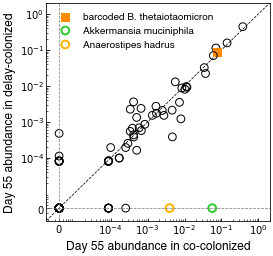

In [98]:
### sort species by mean difference in log-frequency
fig, ax = plt.subplots(figsize=(4,4))

cohort1_final_freqs = np.array( [community_arrays[m]['freqs'][-1] for m in [1,2,3,4,5]] )
cohort2_final_freqs = np.array( [community_arrays[m]['freqs'][-1] for m in [11, 12, 13, 14, 15]] )

pseudocount = 4e-6
cohort1_mean_freq = np.mean(cohort1_final_freqs + pseudocount, axis=0)
cohort2_mean_freq = np.mean(cohort2_final_freqs +  pseudocount,  axis=0)

delta_log = np.abs(np.log(cohort1_mean_freq) - np.log(cohort2_mean_freq))
argsort = np.argsort(delta_log)[::-1]

for i, asv in enumerate(asv_ids):
    rnd1, rnd2 = pseudocount, pseudocount

    x_median, xmin, xmax = np.median(cohort1_final_freqs[:, i]), np.min(cohort1_final_freqs[:, i]), np.max(cohort1_final_freqs[:, i])
    y_median, ymin, ymax = np.median(cohort2_final_freqs[:, i]), np.min(cohort2_final_freqs[:, i]), np.max(cohort2_final_freqs[:, i])

    species = asv_species_map[asv]

    if 'Bacteroides thetaiotaomicron' in species: ## B.theta
        label = 'barcoded B. thetaiotaomicron'
        ax.scatter( np.median(cohort1_final_freqs[:, i]) + rnd1, np.median(cohort2_final_freqs[:, i]) + rnd2, label=label, marker='s', color=asv_colors[asv], s=60)
    
    elif ((np.median(cohort1_final_freqs[:, i])/np.max(cohort2_final_freqs[:, i]) > 100) & (np.median(cohort1_final_freqs[:, i]) > 1e-3)) \
         or ((np.median(cohort2_final_freqs[:, i])/np.max(cohort1_final_freqs[:, i]) > 100) & (np.median(cohort2_final_freqs[:, i]) > 1e-3)):
        
        ax.scatter( np.median(cohort1_final_freqs[:, i]) + rnd1, np.median(cohort2_final_freqs[:, i]) + rnd2, edgecolors=asv_colors[asv], marker='o', facecolors='none',
                    label=species, s=60, linewidth=2)
    else:  
        ax.scatter( np.median(cohort1_final_freqs[:, i]) + rnd1, np.median(cohort2_final_freqs[:, i]) + rnd2, color='black', marker='o', facecolors='none', s=60)


    if (np.median(cohort1_final_freqs[:, i]) == 0) != (np.median(cohort2_final_freqs[:, i]) == 0):
        print(species, cohort1_final_freqs[:, i], cohort2_final_freqs[:, i])
        
ax.legend(loc=2, ncol=1, frameon=False, fontsize=10)

util.plot_diagonal(ax)
ax.set_xlim(1.8e-6, 2)
ax.set_ylim(1.8e-6, 2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(pseudocount, color='grey', linestyle='dashed')
ax.axhline(pseudocount, color='grey', linestyle='dashed')

# ax.axvspan(1.5e-6, 1e-5, color='grey', alpha=0.2)
# ax.axhspan(1.5e-6, 1e-5, color='grey', alpha=0.2)
xticks = ax.get_xticks()
ticks = [pseudocount, 10**-4, 10**-3, 10**-2, 10**-1, 1]
ticklabels = [ r"$0$",
               "$10^{-4}$",
                "$10^{-3}$",
                "$10^{-2}$",
                "$10^{-1}$",
                "$10^{0}$",]
            
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.set_xlabel('Day 55 abundance in co-colonized', fontsize=12)
ax.set_ylabel('Day 55 abundance in delay-colonized', fontsize=12)

fig.savefig(f'{plot_dir}/16s_abundance_correlations_co_vs_delayed.pdf')
fig.savefig(f'../figures/16s_abundance_correlations_co_vs_delayed.svg', format='svg', transparent=True, bbox_inches='tight')
fig.savefig(f'../figures/16s_abundance_correlations_co_vs_delayed.pdf',transparent=True, bbox_inches='tight')

In [104]:
inoculum_strains = ["Enterocloster aldenensis", "Enterocloster bolteae", "Lacrimispora celerecrescens", "Enterocloster citroniae", 
 "Enterocloster clostridioformis", "Hungatella hathewayi", "[Clostridium] hylemonae", "Clostridium innocuum", 
 "Faecalicatena orotica DSM-1287", "Faecalicatena orotica JCM-1429", "Clostridium scindens", "Clostridium symbiosum",
 "Akkermansia muciniphila", "Anaerostipes hadrus", "Bacteroides caccae", "Bacteroides fragilis", "Bacteroides intestinalis", 
 "Bacteroides stercoris", "Bacteroides uniformis", "Phocaeicola vulgatus", "Blautia producta", "Drancourtella massiliensis", 
 "Eggerthella lenta", "Eisenbergiella tayi", "Enterococcus casseliflavus", "Enterococcus faecium", "Enterococcus faecium",
 "Erysipelatoclostridium ramosum", "Escherichia fergusonii", "Flavonifractor plautii" , "Hungatella effluvii", 
 "Klebsiella variicola", "Lachnoclostridium pacaense", "Murimonas intestini", "Parabacteroides distasonis"]
## focus only on ASVs called by DADA that were nominally in the community inoculum
inoculum_indices = []
for strain in inoculum_strains:
    inoculum_indices.append( np.where(species_identities == strain)[0][0] )
inoculum_indices = np.array(inoculum_indices)
# inoculum_bool = np.array([species.strip(' ') in inoculum_strains for species in species_identities])
# print(species_identities[inoculum_bool])
# print([species for species in inoculum_strains if species not in species_identities])


bool_late = np.zeros(len(inoculum_indices))
bool_final = np.zeros(len(inoculum_indices))

bool_1e3 = np.zeros(len(inoculum_indices))
bool_1e4 = np.zeros(len(inoculum_indices))

for m, mouse in enumerate([1,2,3,4,5, 11, 12, 13, 14, 15]):
    # print(f'MOUSE {mouse}')
    days = np.array(community_arrays[mouse]['timepoints'])
    z = np.where( days >= 14)[0][0]

    z_late = np.where(days >= 40)[0][0]

    init_freqs = community_arrays[mouse]['freqs'][1:z]
    late_freqs = np.array(community_arrays[mouse]['freqs'][z:])
    final_freqs = np.array(community_arrays[mouse]['freqs'][z_late:])

    bool_1e3 += ((late_freqs[:, inoculum_indices]>1e-3).sum(axis=0) > 1)
    bool_1e4 += ((late_freqs[:, inoculum_indices]>1e-4).sum(axis=0) > 1)


print('Num species (excl. B.theta0) at >1e-3 consistently after day 14 in a majority of mice =', (bool_1e3 > 5).sum())
print('Num species (excl. B.theta0) at >1e-4 consistently after day 14 in a majority of mice =', (bool_1e4 > 5).sum())


Num species (excl. B.theta0) at >1e-4 in one timepoint in a majority of mice = 0
Num species (excl. B.theta0) at >1e-4 consistently after day 40 in a majority of mice = 0
Num species (excl. B.theta0) at >1e-3 consistently after day 14 in a majority of mice = 26
Num species (excl. B.theta0) at >1e-4 consistently after day 14 in a majority of mice = 32


6 [ 0  3  4  5  6  7  8 12 18 21 25 28 35 55]
7 [ 0  3  4  5  6  7  8 12 15 18 21 25 28 33 35 55]
1 [ 0  3  4  6  7 12 18 21 25 28 33 43 55]
2 [ 0  3  4  5  6  7 15 18 28 35 43 50 55]
11 [14 15 16 17 18 21 25 28 35 50 55]
12 [14 15 16 17 25 28 33 35 50 55]


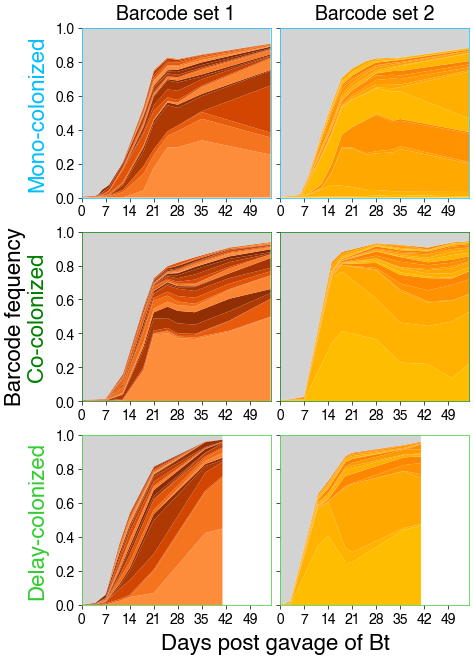

In [24]:

expt = 'E2'
reload(shared)
fig = plt.figure(figsize=(5, 7.5))
gs = plt.GridSpec(nrows=3, ncols=2, figure=fig, wspace=0.05)
outer_ax = fig.add_subplot(gs[:, :])
outer_ax.set_xlabel('Days post gavage of Bt', fontsize=16, labelpad=20)
outer_ax.set_ylabel('Barcode fequency', fontsize=16, labelpad=40)
util.turn_off_ax(outer_ax)

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10


for row, (m_set, condition_color, label) in enumerate(zip([[6, 7], [1, 2], [11, 12]], ['deepskyblue', 'green', 'limegreen'], ['Mono-colonized', 'Co-colonized', 'Delay-colonized'] )):
    for col, (mouse, bc_colors) in enumerate( zip(m_set, ['Oranges', 'Wistia']) ):
        large_indices = shared.find_large_barcodes(expt, [mouse], max_cutoff=1e-2, final_cutoff=2)

        ordered_indices, ordered_colors = shared.order_barcodes_by_pool(large_indices, shared.barcode_pool_assignments, [('S1', 'Oranges'), ('S2', 'Wistia'), 
                                                                                                                         ('S3', 'Blues'), ('S4', 'Purples'),
                                                                                                                         ('E2_shared', 'Greys'), ('E2_ambiguous', 'Greys'), ], cg_at_end=False, cg_all_low_freqs=True)

     
        days, freqs = shared.make_muller_freqs(expt, mouse, ordered_indices, 18, min_depth=10**4, include_pseudo_derepped=True, include_reseq=True)
        print(mouse, days)
        if row == 2:
            days -= 14
        ax = fig.add_subplot(gs[row, col])
        shared.muller_plot(ax, days, ordered_indices, freqs, ordered_colors)

        ax.set_ylim(0, 1)
        ax.set_xlim(0, 55)

        ax.set_xticks([0, 7, 14, 21, 28, 35, 42, 49])


        for spine in ['bottom', 'top', 'right', 'left']:
            ax.spines[spine].set_color(condition_color)
            ax.spines[spine].set_linewidth(0.5)
        ax.tick_params(axis='x', direction='out', width=0.5, length=3)
        ax.tick_params(axis='y', direction='out', width=0.5, length=3)
        
        if row == 0:
            ax.set_title(f'Barcode set {col+1}', fontsize=14)
        if col == 1:
            ax.set_yticklabels([])
        if col == 0:
            ax.set_ylabel(label, fontsize=16, color=condition_color, labelpad=+5, ha='center')

# fig.savefig(f'{plot_dir}/fig5_comm_muller.pdf')
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/fig5_comm_muller.svg', format='svg', transparent=True, bbox_inches='tight')
fig.savefig(f'../figures/fig5_comm_muller.pdf', transparent=True, bbox_inches='tight')



In [25]:
all_arr_indices = set()
for mouse in range(1,16):
    for timept, replicates in shared.library_meta['E2'][mouse].items():
        for (arr_name, arr_idx) in replicates:
            if arr_name == 'reseq':
                all_arr_indices.add( (mouse, timept, arr_idx) )

# all_arr_indices = list(all_arr_indices)
# for z, rep1 in enumerate(all_arr_indices):
#     m1, t1, z1 = rep1
#     rep1_reads = shared.reseq_array[z1]
#     if m1 != 2:
#         continue

#     for rep2 in all_arr_indices[z+1:]:
#         m2, t2, z2 = rep2

#         if t1 == 0 and t2 == 0: 
#             continue
        
#         if m1 == m2:
#             # if np.abs(t1 - t2) < 5 or (t1 in ['cecum', 55] and t2 in ['cecum', 55]):
#             continue
            

#         rep2_reads = shared.reseq_array[z2]
#         corr = np.corrcoef( np.log10(rep1_reads+1), np.log10(rep2_reads+1))[0][1]
#         if corr**2 > 0.24:
#             print('mouse1:', m1, t1, z1, rep1_reads.sum(), 'mouse2:',  m2, t2, z2, rep2_reads.sum(), 'corr^2:', corr**2)


index1 = shared.library_meta['E2'][4][19][0][1]
# index2 = shared.library_meta['E2'][2][21][0][1]
index2 = shared.library_meta['E2'][2][21][0][1]
print(shared.reseq_array[index1].sum(), shared.reseq_array[index2].sum())

# print(index1
shared.library_meta['E2'][14]

fig, ax = plt.subplots()
ax.scatter(shared.reseq_array[index1], shared.reseq_array[index2])
util.plot_diagonal(ax)
ax.set_xscale('log')
ax.set_yscale('log')


KeyError: 19

In [84]:
lib_indices = set()
all_arr_indices = set()
for mouse in range(1,16):
    for timept, replicates in shared.library_meta['E2'][mouse].items():
        for (arr_name, arr_idx) in replicates:
            if arr_name == 'reseq':
                if arr_idx not in lib_indices:
                    if shared.reseq_array[arr_idx].sum() < 1e4:
                        if timept == 'smallint':
                            pass
                        else:
                            print(mouse, timept, arr_idx, shared.reseq_array[arr_idx].sum())
                    lib_indices.add(arr_idx)

1 1 227 1274
1 2 231 25
1 11 274 27
1 17 295 554
1 19 307 1178
1 20 312 1466
1 24 322 1814
1 29 331 868
1 31 336 1821
2 1 228 123
2 2 232 60
2 3 239 155
2 8 267 245
2 9 271 118
2 17 296 380
2 19 308 193
2 20 313 500
2 24 323 1179
2 29 332 4248
2 31 337 5963
3 1 229 36
3 3 240 3649
3 4 246 57
3 8 268 1136
3 9 272 75
3 15 283 116
3 19 309 450
3 20 314 1126
3 24 324 66
3 29 333 4978
3 50 357 153
4 2 233 119
4 3 241 176
4 4 247 77
4 8 269 89
4 11 275 46
4 17 297 211
4 19 310 411
4 20 315 1107
4 24 325 196
4 29 334 202
4 31 339 629
5 0 223 1803
5 1 230 50
5 2 234 63
5 3 242 44
5 8 270 47
5 9 273 12
5 11 276 516
5 16 289 523
5 17 298 776
5 19 311 1166
5 20 316 62
5 24 326 3106
5 29 335 432
5 31 340 727
5 35 345 1385
5 43 351 37
8 7 266 67
11 43 352 35
12 43 353 397
15 cecum 420 3669


In [11]:
import pickle
with open(f'../data/pickled/E1_mean_fitness_traj.pkl', 'rb') as f:
    E1_mean_fitness_trajs  = pickle.load(f)

/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28712/748912308.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28712/748912308.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28712/748912308.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28712/748912308.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedL

6 [ 0  3  4  5  6  7  8 12 18 21 25 28 35 55] [ 745894  150795  278244   94456  122432  192429  212720  524044  125579
  207794  145165  237564  228517 1861441]
0.8945899188441269
Num barcodes considered for lfc calculation in Set 1 col.: 7771
2.5775302702083325e-05 0.0011665710123406896
3 36
4 36
5 35
6 34
7 34
8 33
12 28
18 21
21 18
25 13
28 11
35 4
55 0
3 36
4 36
5 36
6 36
7 36
8 36
12 36
18 28
21 20
25 3
28 6
35 1
55 7
1 [ 0  3  4  5  6  7  8 12 18 21 25 28 33 35 43 50 55] [745894 122400 116039  11039 329956 373387   7082 234231  22539  19303
  25551  28637  22863   1303  25552   5314  38179]
0.8945899188441269
Num barcodes considered for lfc calculation in Set 1 col.: 7771
2.5775302702083325e-05 0.0011665710123406896
3 36
4 36
5 23
6 36
7 34
8 19
12 29
18 19
21 12
25 10
28 10
33 4
35 0
43 1
50 0
55 0
3 35
4 36
5 33
6 36
7 36
8 18
12 35
18 2
21 0
25 0
28 0
33 0
35 0
43 0
50 0
55 0
11 [14 15 16 17 18 21 25 28 33 35 43 50 55] [1030455  220155  311739  209899  258998  305316  335420  

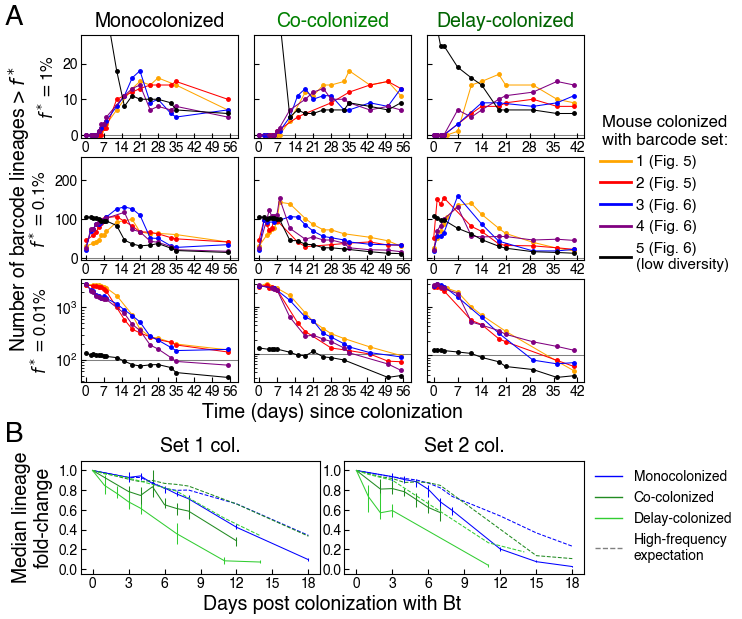

In [30]:
fig = plt.figure(figsize=(6.5, 7))
gs = plt.GridSpec(5,3, figure=fig, height_ratios=[1, 1, 1, 0.4, 1.1], wspace=0.1)
legend_ax = fig.add_subplot(gs[:])
util.turn_off_ax(legend_ax)
legend_markers = [ mpl.lines.Line2D((0,), (0,), color='orange',  linestyle='solid', lw=2),
                    mpl.lines.Line2D((0,), (0,), color='red', linestyle='solid', lw=2),
                    mpl.lines.Line2D((0,), (0,), color='blue', linestyle='solid', lw=2),
                    mpl.lines.Line2D((0,), (0,), color='purple', linestyle='solid', lw=2),
                    mpl.lines.Line2D((0,), (0,), color='black', linestyle='solid', lw=2),]


outer_ax = fig.add_subplot(gs[:3, :])
util.turn_off_ax(outer_ax)
outer_ax.set_ylabel(r'Number of barcode lineages > $f^*$', fontsize=14, labelpad=35)
outer_ax.set_xlabel(r'Time (days) since colonization', fontsize=14, labelpad=15)
outer_ax.legend(legend_markers, ['1 (Fig. 5)', '2 (Fig. 5)', '3 (Fig. 6)', '4 (Fig. 6)', '5 (Fig. 6)\n(low diversity)'],
          title="Mouse colonized\nwith barcode set:", title_fontsize=12,
          loc=(1.02, 0.3), frameon=False, fontsize=11, ncol=1,
          handletextpad=0.3, bbox_transform=legend_ax.transAxes)
outer_ax.text(-0.15, 1.03, 'A', fontsize=20)

E2_mouse_colors = {1:'orange', 2:'red', 3:'blue', 4:'purple', 5:'black',
                    6:'orange', 7:'red', 8:'blue', 9:'purple', 10:'black',
                    11:'orange', 12:'red', 13:'blue', 14:'purple', 15:'black'}
            
for row, (cutoff, cutoff_label) in enumerate(zip([1e-2, 1e-3, 1e-4], ['1%', '0.1%', '0.01%'])):
    for col, (mice, label, color) in enumerate(zip([[6,7, 8, 9, 10], [1,2,3,4, 5], [11, 12, 13, 14, 15]],
                                                   ['Monocolonized', 'Co-colonized', 'Delay-colonized'],
                                                   ['black', 'green', 'darkgreen'])):
        ax = fig.add_subplot(gs[row, col])
        min_depth = np.min([10**4, cutoff**-1. * 3])
        for mouse in mice:
            days, n_barcodes_above_cutoff = shared.estimate_num_barcodes_above_cutoff('E2', mouse, cutoff, min_depth=min_depth)

            if label == 'Delay-colonized':
                days -= 14
            ax.plot(days, n_barcodes_above_cutoff, marker='.', markersize=5, color=E2_mouse_colors[mouse], linestyle='solid', label=f'set {mouse-5}')
            # sim_days, sim_n_barcodes_above_cutoff = shared.estimate_num_barcodes_above_cutoff_simulated('E2', mouse, cutoff, Ntau=10**6, min_depth=min_depth)
            # ax.plot(sim_days, sim_n_barcodes_above_cutoff, color='grey', zorder=0)

        if row == 0: 
            ax.set_title(label, color=color, fontsize=14)
        if col == 0:
            ax.set_ylabel(r'$f^*=$' + f'{cutoff_label}', fontsize=12)

        ax.set_xlim(-2, 59)
        ax.set_xticks([0, 7, 14, 21, 28, 35, 42, 49, 56])
        ax.set_xticklabels([0, 7, 14, 21, 28, 35, 42, 49, 56], fontsize=10)

        if row == 2:
            # ax.set_ylim(1, 3500)
            # ax.set_yticks([100]+list(ax.get_yticks()))
            # ax.set_yticks([1, 100, 1000, 2000, 3000])
            ax.axhline(100, color='grey', zorder=0)
            ax.set_yscale('log')
        if row == 1:
            ax.set_ylim(-5, 260)
            ax.axhline(0, color='grey', zorder=0)
        if row == 0:
            ax.set_ylim(-1, 28)
            ax.axhline(0, color='grey', zorder=0)
        if col != 0:
            ax.set_yticklabels([])
        if col == 2:
            ax.set_xlim([-2, 44])
            ax.set_xticks([0, 7, 14, 21, 28, 35, 42])
        #     ax.set_xticklabels([14, 21, 28, 35, 42, 49, 56], fontsize=10)
        else:
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

        # if row == 2 and col == 0:
        #     ax.legend(loc=1, frameon=False, fontsize=8)

## median fold change
reload(shared)
mfc_gs = mpl.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[-1, :], wspace=0.1, hspace=0.1)
mfc_outer = fig.add_subplot(gs[-1, :])
util.turn_off_ax(mfc_outer)
mfc_outer.set_xlabel('Days post colonization with Bt', fontsize=14, labelpad=15)
mfc_outer.set_ylabel('Median lineage\nfold-change', fontsize=14, labelpad=20)
mfc_outer.text(-0.15, 1.17, 'B', fontsize=20)

min_freq = 0
Ntau = 10**5 #days
MIN_GROUP_SIZE = 30

mice_in_each_col = [[6,1,11], [7, 2, 12]]
mouse_colors = {6:'blue', 7:'blue', 1:'forestgreen', 2:'forestgreen', 11:'limegreen', 12:'limegreen'}
for z, (m_set, inoc_bool, title) in enumerate( zip(mice_in_each_col,
                                        [shared.barcode_pool_assignments['S1'][1], shared.barcode_pool_assignments['S2'][1]], 
                                        ['Set 1 col.', 'Set 2 col.']) ):
    ax = fig.add_subplot(mfc_gs[z])
    for m, mouse in enumerate(m_set):
        ## Group barcodes by initial frequency for fold-change plot
        day0 = 0 if mouse < 10 else 14
        plot_days, mouse_reads, mouse_depths = shared.get_mouse_timecourse('E2', mouse)
        mouse_freqs = shared.calc_freqs(mouse_reads, mouse_depths)
        print(mouse, plot_days, mouse_depths)
        
        barcode_groups = []
        barcode_ranges = []
        neutral_sim_frequencies = sim.neutral_sim(mouse_freqs[0], Ntau, plot_days, mouse_depths)

        # high freq. expectation
        max_freqs = np.max(mouse_freqs, axis=0)
        high_frequency_barcodes = np.where(max_freqs > 1e-2)[0]
        high_frequency_expected_freqs = shared.high_frequency_expectation(plot_days, mouse_freqs, high_frequency_barcodes, mouse_depths, Ntau=Ntau, min_day=day0) 


        day0_reads = mouse_reads[0]
        day0_freqs = mouse_freqs[0]
        # lower = MIN_READS
        lower = np.percentile(day0_reads[inoc_bool][day0_reads[inoc_bool] > 0], 50)
        max_reads = np.percentile(day0_reads[inoc_bool][day0_reads[inoc_bool] > 0], 99.9)
        upper = lower * 1.1
        print( np.sum(day0_freqs[ (day0_reads > lower) & (day0_reads < max_reads)]) )

        while upper < max_reads:
            indices = np.where( (day0_reads >= lower) & (day0_reads < upper) )[0]
            if len(indices) < MIN_GROUP_SIZE:
                upper *= 1.1
                continue
            barcode_ranges.append( (lower, upper) )
            lower = upper
            upper = lower * 1.1
            barcode_groups.append(indices)
            
        print( f'Num barcodes considered for lfc calculation in {title}:', np.sum([len(g) for g in  barcode_groups]) )
        print( np.min(barcode_ranges)/day0_reads.sum(), np.max(barcode_ranges)/day0_reads.sum() )

        for freqs, color, ls in zip([high_frequency_expected_freqs, mouse_freqs], [mouse_colors[mouse], mouse_colors[mouse]], ['dashed', 'solid']):

            median_lfcs = shared.calc_median_lfc(freqs, mouse_depths, barcode_groups=barcode_groups)
            x, y, yerr = [day0], [1], [[0, 0]]
            for day, depth, median_lfcs_in_groups in zip(plot_days[1:], mouse_depths[1:], median_lfcs):
                print(day, len(median_lfcs_in_groups))
                if len(median_lfcs_in_groups) < 4 or depth < 2*10**3 or day-day0 > 18:
                    continue
                
                medians = [median for (median, group_lfcs) in median_lfcs_in_groups]
                lfcs = [group_lfcs for (median, group_lfcs) in median_lfcs_in_groups]
                # print(mouse, day, np.median(medians), np.sum([len(l) for l in lfcs]))

                median_of_medians = np.exp(np.median(medians))
                quartiles = np.exp([np.percentile(medians, 25), np.percentile(medians, 75)])
                deltas = [median_of_medians- quartiles[0], quartiles[1] - median_of_medians]

                x.append(day)
                y.append(median_of_medians)
                yerr.append(deltas)

            x = np.array(x)
            if ls == 'dashed': # high frequency expectation
                yerr = 0
            ax.errorbar(x-day0, y, yerr=np.transpose(yerr), color=color, ls=ls)
        # ax.plot(E1_mean_fitness_trajs[8][0], E1_mean_fitness_trajs[8][1], color='grey', ls=ls, lw=1)

    if 'format':
        ax.set_title(title, fontsize=14)
        ax.set_ylim(-0.05, 1.1)
        ax.set_xlim(-1, 19)
        ax.set_xticks([0,3,6,9,12,15,18])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_xticklabels([0,3,6,9,12,15,18], fontsize=10)

legend_markers = [ mpl.lines.Line2D((0,), (0,), color=c,  linestyle='solid', lw=1) for c in ['blue', 'forestgreen', 'limegreen']]  \
                    + [mpl.lines.Line2D((0,), (0,), color='grey', linestyle='dashed', lw=1)]
ax.legend(legend_markers, ['Monocolonized', 'Co-colonized', 'Delay-colonized', 'High-frequency\nexpectation'], 
          loc=(1.02, 0.05), bbox_transform=ax.transAxes, fontsize=10, frameon=False)


fig.savefig(f'{plot_dir}/fig5_si_num_barcodes_above_cutoff.pdf')
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/sfig_E2_num_barcodes_detected.svg')
fig.savefig(f'../figures/sfig_E2_num_barcodes_detected.pdf')

In [3]:
with open(f'{data_dir}/pickled/vivo_fitness_dict.pkl', 'rb') as f:
    invivo_fitness_dict = pickle.load(f)


print(len(invivo_fitness_dict['SD1']))

728


728
722
555


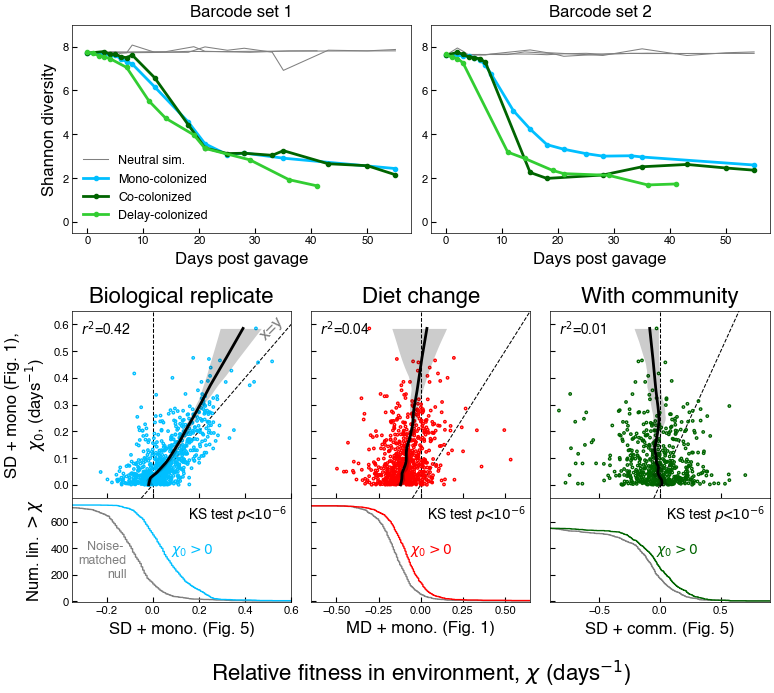

In [6]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

#### MASTER FIGURE ####
fig = plt.figure(figsize=(9, 7.5))
gs = plt.GridSpec(nrows=4, ncols=6, height_ratios=(2, 0.75, 1.8,1), hspace=0, figure=fig, wspace=0.2)



### ENTROPY PLOTS ####
plot_sets = [
              ([(6,), (1,), (11,)], ['deepskyblue', 'darkgreen', 'limegreen'],
               ['E2', 'E2', 'E2'], ['Mono-colonized', 'Co-colonized', 'Delay-colonized']),
              ([(7,), (2,), (12,)], ['deepskyblue', 'darkgreen', 'limegreen'],
               ['E2', 'E2', 'E2'], ['Mono', 'Comm', 'Delay']),
]
min_freq = 1e-4
# entropy_ax = fig.add_subplot(gs[0, 3*0:3*(0+1)])
for c, (mice_sets, colors, expts, labels) in enumerate(plot_sets):
    entropy_ax = fig.add_subplot(gs[0, 3*c:3*(c+1)])

    linestyle='solid'
    # if c == 1:
    #     linestyle='dashed'
    for z, (m_set, colors, expt, label) in enumerate( zip(mice_sets, colors, expts, labels) ):
        for mouse in m_set:
            plot_days, mouse_reads, mouse_depths = shared.get_mouse_timecourse(expt, mouse)
            if mouse > 10:
                plot_days -= 14
            mouse_freqs = shared.calc_freqs(mouse_reads, mouse_depths)


            mouse_large_entropies = shared.calc_entropy(mouse_freqs, min_freq=min_freq)

            neutral_sim_frequencies = sim.neutral_sim(mouse_freqs[0], 10**6, plot_days, mouse_depths)
            expected_neutral_entropies = shared.calc_entropy(neutral_sim_frequencies, min_freq=min_freq)

            neut_label = ''
            if c == 0 and z == 0:
                neut_label = 'Neutral sim.'
            entropy_ax.plot(plot_days[:], expected_neutral_entropies, color='grey', linestyle=linestyle, label=neut_label, zorder=0)

            entropy_ax.plot(plot_days, mouse_large_entropies, color=colors, label=label, linestyle=linestyle, marker='.', lw=2)

    if c == 0:
        entropy_ax.set_ylabel('Shannon diversity', fontsize=12)
        entropy_ax.set_title('Barcode set 1', fontsize=12)
        entropy_ax.legend(loc=3, frameon=False, fontsize=9)
    else:
        entropy_ax.set_title('Barcode set 2', fontsize=12)

    entropy_ax.set_ylim(-0.5, 9)
    entropy_ax.set_xlabel('Days post gavage', fontsize=12)

    for spine in ['top', 'right', 'left', 'bottom']:
        entropy_ax.spines[spine].set_linewidth(0.5)

### JDFE ###
cumulative = True
log = False
plot_mean = False

outer_ax = fig.add_subplot(gs[3, :])
util.turn_off_ax(outer_ax)
outer_ax.set_xlabel('Relative fitness in environment, $\chi$ (days$^{-1}$)', labelpad=40, fontsize=16)
SD_SD_ax = fig.add_subplot(gs[2, 0:2])
SD_cdf_ax = fig.add_subplot(gs[3, 0:2])
SD_MD_ax = fig.add_subplot(gs[2, 2:4])
MD_cdf_ax = fig.add_subplot(gs[3, 2:4])
SD_comm_ax = fig.add_subplot(gs[2, 4:6])
comm_cdf_ax = fig.add_subplot(gs[3, 4:6])


for label, scatter_ax, cdf_ax, color, (lfc_x, lfc_y, null) in zip(
        ['SD + mono. (Fig. 5)', 'MD + mono. (Fig. 1)', 'SD + comm. (Fig. 5)', ''],
        [SD_SD_ax, SD_MD_ax, SD_comm_ax, SD_comm_ax],
        [SD_cdf_ax, MD_cdf_ax, comm_cdf_ax, comm_cdf_ax],
        ['deepskyblue', 'red', 'darkgreen', 'limegreen'],
        [('SD2', 'SD1', 'SD2_null'),
         ('MD', 'SD1', 'MD_null'),
         ('comm', 'SD1', 'comm_null')]):

    lfcs_x = np.array(invivo_fitness_dict[lfc_x])
    lfcs_y = np.array(invivo_fitness_dict[lfc_y])
    null = np.array(invivo_fitness_dict[null])


    valid = (~np.isnan(lfcs_x))*(~np.isnan(null))*(lfcs_x != 0)*(null != 0) #exclude 
    r = scipy.stats.pearsonr(lfcs_x[valid], lfcs_y[valid])[0]
    scatter_ax.scatter(lfcs_x[valid], lfcs_y[valid], color=color, s=3, marker='o', facecolor='none')
    scatter_ax.text(0.04, 0.96, f"$r^2$={r**2:.2f}", transform=scatter_ax.transAxes, fontsize=10, ha='left', va='top')

    if 'lowess':
        lowess_x, lowess_y = lfcs_x[valid], lfcs_y[valid]
        lowess_fit = sm.nonparametric.lowess(lowess_x, lowess_y, frac=0.40)
        scatter_ax.plot(lowess_fit[:, 1], lowess_fit[:, 0], color='black', lw=2)

        y_values_to_evaluate = np.linspace(0, np.max(lowess_y), 100)
        

        zip_lfcs = np.array(list(zip(lowess_x, lowess_y)))
        n_bootstraps = 100
        lowess_bootstraps = np.zeros((n_bootstraps, len(y_values_to_evaluate)))
        print(len(zip_lfcs))
        for i in range(n_bootstraps):
            bootstrapped_data = rnd.choice(zip_lfcs, size=len(zip_lfcs), replace=True)
            
            bootstrapped_lowess = sm.nonparametric.lowess(bootstrapped_data[:, 0], bootstrapped_data[:, 1], frac=0.30, xvals=y_values_to_evaluate)
            lowess_bootstraps[i] = bootstrapped_lowess
        
        upper_percentile = np.percentile(lowess_bootstraps, 97.5, axis=0)
        lower_percentile = np.percentile(lowess_bootstraps, 2.5, axis=0)
        # percentile25 = np.percentile(lowess_bootstraps, 95, axis=0)
        # percentile75 = np.percentile(lowess_bootstraps, 5, axis=0)

        scatter_ax.fill_betweenx(y_values_to_evaluate, lower_percentile, upper_percentile, color='black', lw=0, alpha=0.2)


    if cumulative:
        binspace=np.linspace(-2, 2, 641)
        cdf_ax.hist(null[valid], bins=binspace, histtype='step', color='grey', cumulative=-1, log=log, label='Null')
        cdf_ax.hist(lfcs_x[valid], bins=binspace, histtype='step', color=color, cumulative=-1, log=log, label='(SD+mono.)-fit')
        cdf_ax.set_ylim(-10, 850)
    else:
        binspace=np.linspace(-1, 1, 81)
        cdf_ax.hist(null[valid], bins=binspace, histtype='step', color='grey', log=log, label='Null')
        cdf_ax.hist(lfcs_x[valid], bins=binspace, histtype='step', color=color, log=log, label='(SD+mono.)-fit')
        cdf_ax.set_ylim(-20, 95)

    _, ks_pval = scipy.stats.kstest(np.array(lfcs_x)[valid], np.array(null)[valid])
    if ks_pval < 1e-6: pval_text='$p$<'+ f'$10^{{{-6}}}$'
    elif ks_pval < 0.01: pval_text=f'$p$' +f'${as_si(10**-6,1)}$'
    else: pval_text=f'p={ks_pval:.0e}'
    cdf_ax.text(0.98, 0.95, f'KS test {pval_text}', transform=cdf_ax.transAxes, fontsize=10, ha='right', va='top')
    cdf_ax.set_xlabel(label, fontsize=12)

    if plot_mean:
        cdf_ax.axvline( np.median(np.array(lfcs_x)[valid]), color=color, zorder=10, lw=1.5)
        cdf_ax.axvline( np.median(np.array(null)[valid]), color='grey', zorder=0, lw=1.5)

SD_SD_ax.text(0.98, 0.83, 'x=y', transform=SD_SD_ax.transAxes, color='grey', fontsize=12, ha='right', va='bottom', rotation=45)


for (ax, cdf_ax, title, color, xlims) in zip([SD_SD_ax, SD_MD_ax, SD_comm_ax],
                               [SD_cdf_ax, MD_cdf_ax, comm_cdf_ax],
                               ['Biological replicate', 'Diet change', 'With community'],
                               ['deepskyblue', 'red', 'darkgreen'],
                               [(None, None), (-0.6, 0.6), (None, None)]):
    # ax.set_ylim(-0.05, 0.65)
    util.plot_diagonal(ax)
    ax.axvline(0, color='black', linestyle='dashed', zorder=0)
    ax.set_ylim(-0.05, 0.65)
    cdf_ax.set_ylim(-10, 780)

    if title == 'Biological replicate':
        cdf_ax.set_xlim(-0.35, 0.6)
        ax.set_xlim(-0.35, 0.6)
        cdf_ax.text(0.45, 0.5, "$\chi_0>0$", color='deepskyblue', transform=cdf_ax.transAxes, fontsize=10, ha='left', va='center')
    elif title == 'Diet change':
        cdf_ax.set_xlim(-0.65, 0.65)
        ax.set_xlim(-0.65, 0.65)
        cdf_ax.text(0.45, 0.5, "$\chi_0>0$", color='red', transform=cdf_ax.transAxes, fontsize=10, ha='left', va='center')
    elif title == 'With community':
        cdf_ax.set_xlim(-0.9, 0.9)
        ax.set_xlim(-0.9, 0.9)
        cdf_ax.text(0.48, 0.5, "$\chi_0>0$", color='darkgreen', transform=cdf_ax.transAxes, fontsize=10, ha='left', va='center')

    ax.set_xticklabels([])
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_linewidth(0.5)
        cdf_ax.spines[spine].set_linewidth(0.5)

    # cdf_ax.set_xlim(ax.get_xlim())
    # cdf_ax.set_xticks(ax.get_xticks())
    ax.set_title(title, fontsize=16)
    if ax != SD_SD_ax:
        ax.set_yticklabels([])
        cdf_ax.set_yticklabels([])
    else:
        ax.set_ylabel('SD + mono (Fig. 1),\n$\chi_0$, (days$^{-1}$)', fontsize=12)
        cdf_ax.set_ylabel('Num. lin. $>\chi$', fontsize=12)
        cdf_ax.text(0.25, 0.4, "Noise- \nmatched\nnull", color='grey', transform=cdf_ax.transAxes, fontsize=9, ha='right', va='center')


# fig.savefig(f'{plot_dir}/fig5_invivo_jdfe.pdf')
# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig(f'../figures/fig5_invivo_jdfe.svg', format='svg', transparent=True, bbox_inches='tight')
# fig.savefig(f'../figures/fig5_invivo_jdfe.pdf', transparent=True, bbox_inches='tight')

In [22]:
np.percentile( shared.vivo_depths[:, 0]/shared.vivo_depths[:, 1], 5)
# np.percentile( shared.vivo_depths[:, 0]/shared.vivo_depths[:, 1], 95)

9.7147923203122

In [58]:
shared.library_meta['E1'][13]

{0: [('vivo', 0)],
 1: [('vivo', 14)],
 2: [('vivo', 26)],
 3: [('vivo', 36), ('reseq', 11)],
 4: [('reseq', 21)],
 6: [('reseq', 43)],
 7: [('reseq', 51)],
 9: [('vivo', 83)],
 15: [('vivo', 110)],
 17: [('vivo', 131)],
 19: [('vivo', 147), ('reseq', 121)],
 20: [('vivo', 156)],
 21: [('vivo', 166), ('reseq', 135)],
 22: [('vivo', 179), ('reseq', 147)],
 27: [('vivo', 190), ('reseq', 154)],
 29: [('vivo', 201), ('reseq', 163)],
 33: [('vivo', 212), ('reseq', 170)],
 40: [('vivo', 229), ('reseq', 179)]}